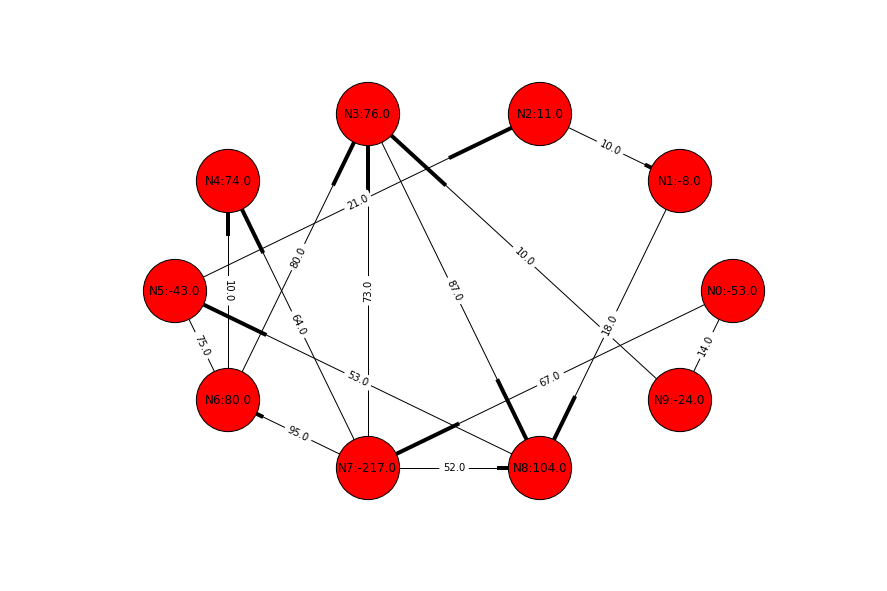

In [171]:
import networkx as nx
import numpy as np
import scipy as sp
from scipy.sparse import rand
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt 
%matplotlib inline

# generate test data
np.random.seed(42)

def generate_adj_matrix(people_number, fill_factor = 0.5, hide_negative = True):
    fill_coeff = int(people_number * fill_factor)
    adj_matrix = sp.sparse.rand(people_number,
                                people_number,
                                density = fill_factor,
                                format = 'csr',
                                random_state = np.random.randint(1))

    adj_matrix = adj_matrix.todense()
    adj_matrix[np.arange(people_number), np.arange(people_number)] = 0
    adj_matrix = adj_matrix - adj_matrix.T
    
    if hide_negative:
        adj_matrix[adj_matrix < 0] = 0
    
    for i in range(people_number):
        for j in range(people_number):
            adj_matrix[i, j] = int(100 * adj_matrix[i, j])
    
    return csr_matrix(adj_matrix)


# compute node balance
def balance(G, i):
    balance = 0
    
    sparse_matrix = nx.adjacency_matrix(G)
    
    balance += sparse_matrix[:, i].sum()
    balance -= sparse_matrix[i, :].sum()
            
    return balance
    

def draw_graph(G, show_edges_labels = True):
    plt.figure(figsize = (15,10))
    plt.axis('off')

    pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 4000)
    nx.draw_networkx_edges(G, pos)
    
    if show_edges_labels:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
    
    labels = {}

    for node in G.nodes():
        labels[node] = ':'.join(['N' + str(node), str(balance(G, node))])
        
    nx.draw_networkx_labels(G, pos, labels = labels)
    

# check solution
def check_solution(G_orig, G_resolved):
    for node in G_orig.nodes():
        if balance(G_orig, node) != balance(G_resolved, node):
            return False
        
    return True


people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)
G = nx.DiGraph(data)

draw_graph(G)

First aproach is delete all the previous connections, all the creditors should be satisfied with debtors using the least possible amount of arcs between them. 

Solution is valid


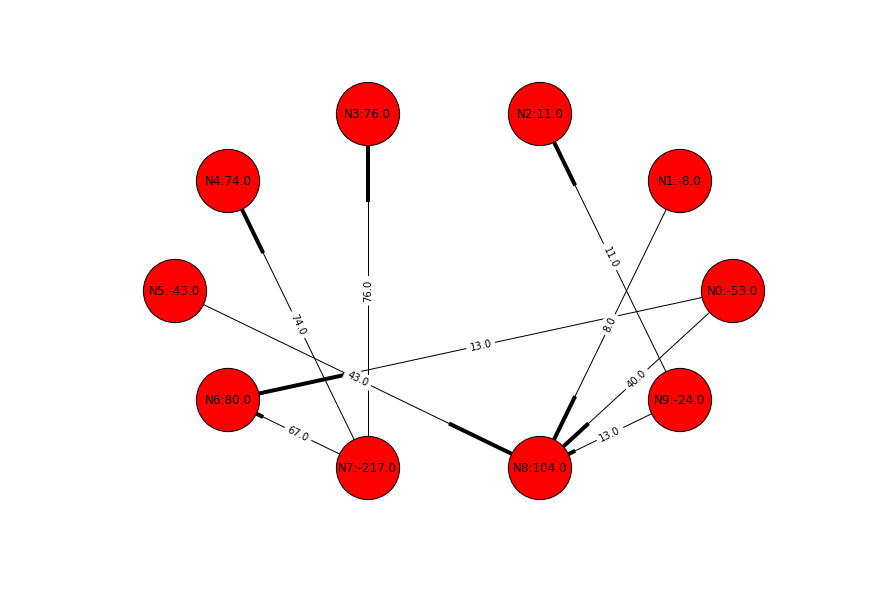

In [169]:
import cvxpy as cvx

class Solver1():
    def solve(self, data):
        u = data.copy()
        people_number = data.shape[0]

        x = cvx.Variable(people_number, people_number)
        c = cvx.Variable(people_number, people_number)

        constraints = [cvx.sum_entries(c, axis=1) == cvx.pos(u.sum(axis=1) - u.sum(axis=0).T),
                       cvx.sum_entries(c, axis=0) == cvx.pos(u.sum(axis=0) - u.sum(axis=1).T),
                       c <= x,
                       c >= 0]

        obj = cvx.Minimize(cvx.sum_entries(x))

        prob = cvx.Problem(obj, constraints)
        prob.solve(solver='GUROBI')
#         print 'optimal value:', prob.value
#         print 'optimal x: \n', x.value
        return x.value

solver1 = Solver1()

G_solution = nx.DiGraph(solver1.solve(data))
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

Solution is valid


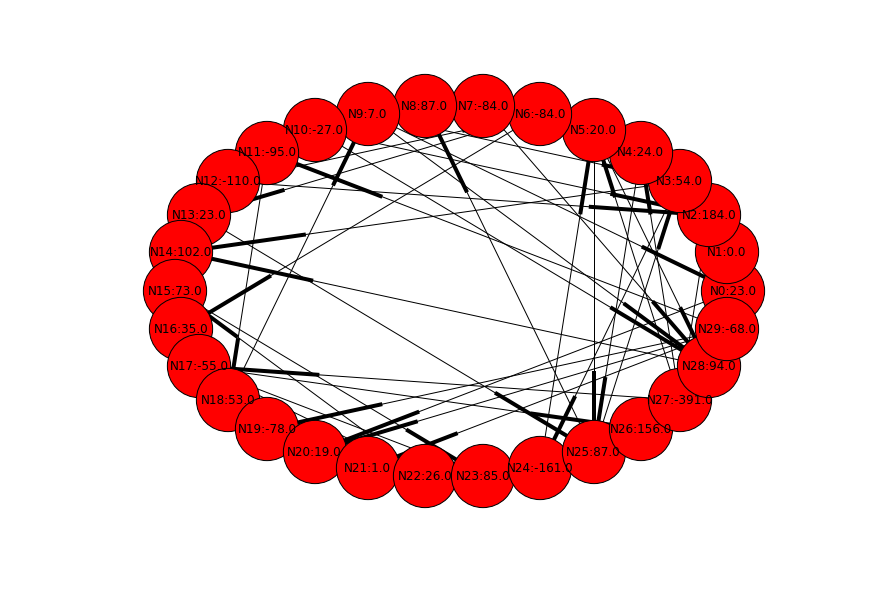

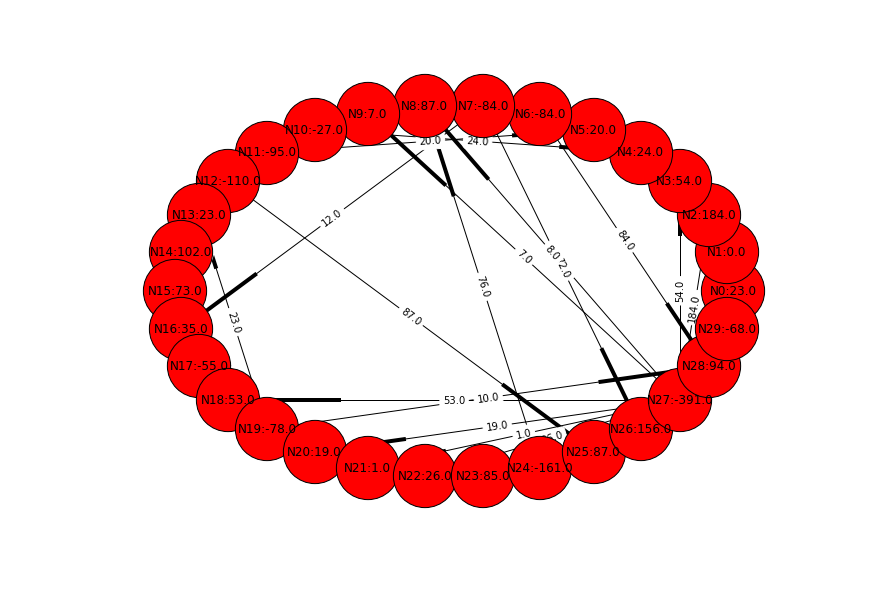

In [173]:
data = generate_adj_matrix(people_number * 3, 0.05, True)
G = nx.DiGraph(data)
G_solution = nx.DiGraph(solver1.solve(data))
draw_graph(G, show_edges_labels = False)
draw_graph(G_solution)

if check_solution(G, G_solution):
    print('Solution is valid')

The maxium problem size that can be solved using this approach is 30 people graph. The problem is that given problem is NP-hard.

Let's try another formualtion.
At first we want to kill all the cycles. The order matters and thus we want to solve the following problem:
* Kill cycles
* Not to create new relationships between nodes
* Reduce mutual debts

There is a property: given graph G, each node i of G has some input and some output verticies $V_{ji}$ and $V_{ij}$ respectively.

$b_i$ is the total balance of a node i is defined as follows: 
$$b_i =\sum_{j} V_{ji} - V_{ij}  $$

Here let's see what is the result of random cycle killing.

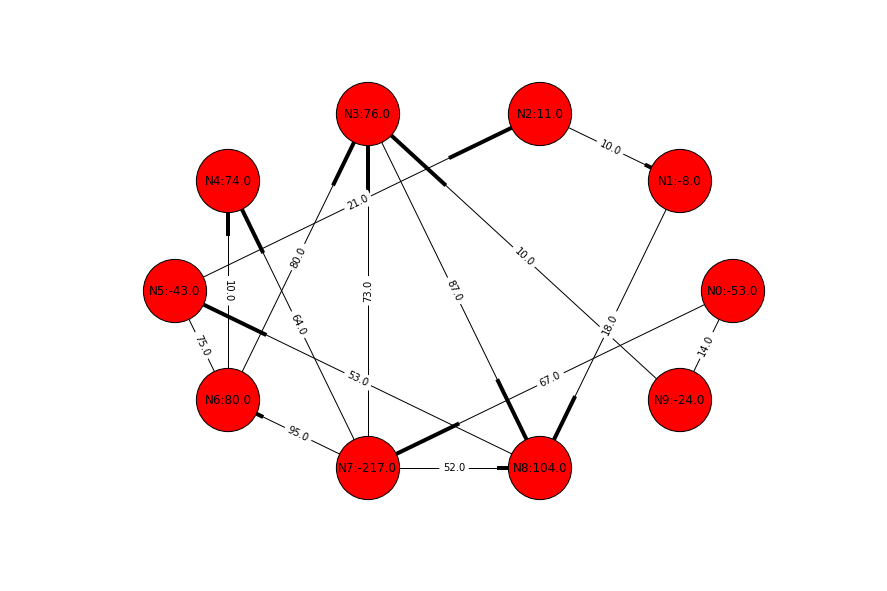

In [174]:
people_number = 10
data = generate_adj_matrix(people_number, 0.2, True)
G = nx.DiGraph(data)
draw_graph(G)

In [177]:
nx.algorithms.cycles.cycle_basis(G)

NetworkXNotImplemented: not implemented for directed type